# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pmdarima.arima import auto_arima

In [2]:
data = pd.read_excel('data.xlsx')

In [3]:
data.set_index(pd.to_datetime(data[["YEAR", "MONTH"]].assign(DAY=1)), inplace = True)

In [4]:
data.drop(['YEAR','MONTH','HANSGN'], axis = 1, inplace = True)

In [5]:
data

,TTT
2015-01-01,1436819
2015-02-01,1541333
2015-03-01,1680903
2015-04-01,1684774
2015-05-01,1772993
2015-06-01,1981326
2015-07-01,2217722
2015-08-01,1945915
2015-09-01,1689386
2015-10-01,1784537


<AxesSubplot:>

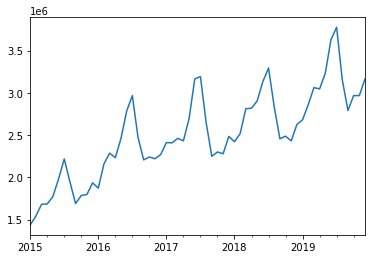

In [6]:
data['TTT'].plot()

In [7]:
train = data[:-12].copy()
test = data[-12:].copy() # last 6 months as test set

In [8]:
test

,TTT
2019-01-01,2680573
2019-02-01,2860436
2019-03-01,3061302
2019-04-01,3045879
2019-05-01,3230488
2019-06-01,3627333
2019-07-01,3775263
2019-08-01,3151724
2019-09-01,2789760
2019-10-01,2966733


# 2. Time Series Analysis

In [9]:
# Stationarity test:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.968342
Critical Values at 0.05: -2.94
p-value: 0.001586
Stationary


In [10]:
kpss_test = kpss(train)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if result[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.795515
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


<AxesSubplot:>

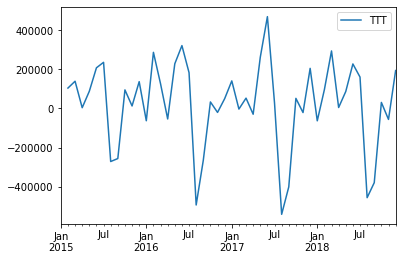

In [11]:
train1 = train - train.shift(1)
train1.plot()

In [12]:
# Stationarity test:
result = adfuller(train1.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -6.515841
p-value: 0.000000
Stationary


In [13]:
kpss_test = kpss(train1.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if result[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.071539
Critical Values @ 0.05: 0.46
p-value: 0.100000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<AxesSubplot:>

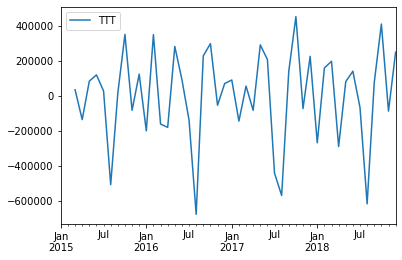

In [14]:
train2 = train1 - train1.shift(1)
train2.plot()

In [15]:
# Stationarity test:
result = adfuller(train2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -8.114814
p-value: 0.000000
Stationary


In [16]:
kpss_test = kpss(train2.dropna())

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if result[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 0.500000
Critical Values @ 0.05: 0.46
p-value: 0.041667
Not stationary


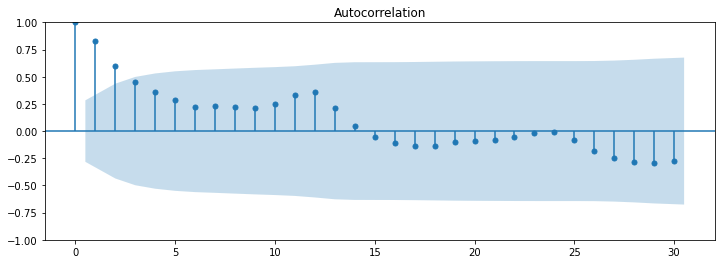

In [17]:
# Check ACF and PACF:
plt.figure(figsize=(12,4))
plot_acf(train, ax=plt.gca(), lags = 30)
plt.show()

C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


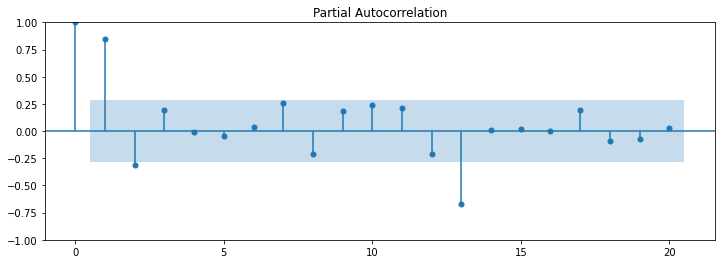

In [18]:
plt.figure(figsize=(12,4))
plot_pacf(train, ax=plt.gca(), lags = 20)
plt.show()

Conclusion:
- Because the time series is stationary, d value should be 2
- Based on ACF plot, q value should be 3
- Based on PACF plot, p value should be 1

# 3. Build models

## 3.1. ARIMA with d = 1

In [33]:
model = auto_arima(train,
                   d = 3,
                   start_p = 1,
                   max_p = 13,
                   start_q = 0,
                   max_q = 2,
                   m = 12,
                   seasonal = True,
                   trace = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,0)(1,1,1)[12]             : AIC=913.021, Time=0.13 sec
 ARIMA(0,3,0)(0,1,0)[12]             : AIC=935.270, Time=0.08 sec
 ARIMA(1,3,0)(1,1,0)[12]             : AIC=913.656, Time=0.04 sec
 ARIMA(0,3,1)(0,1,1)[12]             : AIC=897.827, Time=0.09 sec
 ARIMA(0,3,1)(0,1,0)[12]             : AIC=902.378, Time=0.03 sec
 ARIMA(0,3,1)(1,1,1)[12]             : AIC=896.241, Time=0.11 sec
 ARIMA(0,3,1)(1,1,0)[12]             : AIC=896.091, Time=0.06 sec
 ARIMA(0,3,1)(2,1,0)[12]             : AIC=896.415, Time=0.18 sec
 ARIMA(0,3,1)(2,1,1)[12]             : AIC=898.237, Time=0.34 sec
 ARIMA(0,3,0)(1,1,0)[12]             : AIC=914.310, Time=0.03 sec
 ARIMA(1,3,1)(1,1,0)[12]             : AIC=897.064, Time=0.08 sec
 ARIMA(0,3,2)(1,1,0)[12]             : AIC=895.532, Time=0.10 sec
 ARIMA(0,3,2)(0,1,0)[12]             : AIC=897.393, Time=0.05 sec
 ARIMA(0,3,2)(2,1,0)[12]             : AIC=896.495, Time=0.23 sec
 ARIMA(0,3,2)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   48
Model:             SARIMAX(1, 3, 2)x(1, 1, [1], 12)   Log Likelihood                -440.668
Date:                              Tue, 20 Dec 2022   AIC                            893.335
Time:                                      10:35:44   BIC                            902.314
Sample:                                  01-01-2015   HQIC                           896.356
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8223      0.546     -1.506      0.132      -1.892       0.248
ma.L1         -0.1124      0.589     -0.191      0.849      -1.266       1.042
ma.L2         -0.8486      0.536     -1.583      0.113      -1.899       0.202
ar.S.L12      -0.7463      0.651     -1.147      0.251      -2.022       0.529
ma.S.L12       0.6104      0.792      0.771      0.441      -0.941       2.162
sigma2      3.324e+10   1.69e-11   1.96e+21      0.000    3.32e+10    3.32e+10
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.27   Prob(JB):                         0.97
Heteroskedasticity (H):               1.56   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+37. Standard errors may be unstable.
"""

In [34]:
# Predict using the best model from auto_arima:
test['predict'] = pd.Series(model.predict(12).astype('int64'))

In [35]:
test

,TTT,predict
2019-01-01,2680573,2764231
2019-02-01,2860436,2841604
2019-03-01,3061302,3128380
2019-04-01,3045879,3159322
2019-05-01,3230488,3294846
2019-06-01,3627333,3595730
2019-07-01,3775263,3763007
2019-08-01,3151724,3318390
2019-09-01,2789760,2942155
2019-10-01,2966733,3010190


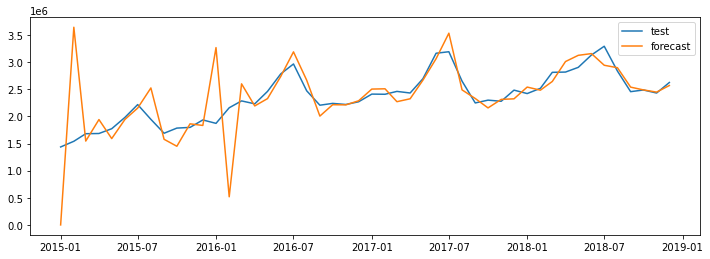

In [36]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(train, label='test')
plt.plot(model.predict_in_sample(), label='forecast')
plt.legend(loc='best')
plt.show()

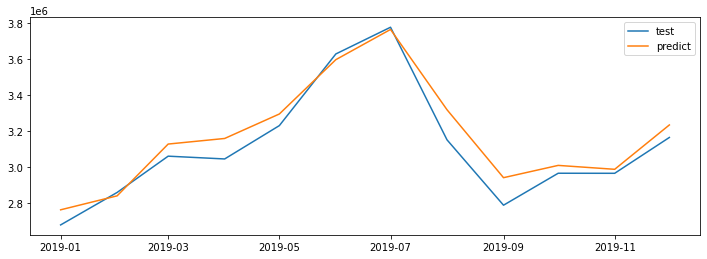

In [37]:
# Plot test vs forecast
plt.figure(figsize=(12,4))
plt.plot(test['TTT'], label='test')
plt.plot(test['predict'], label='predict')
plt.legend(loc='best')
plt.show()

In [38]:
rmse = np.sqrt(mean_squared_error(test['TTT'], test['predict'])).round(2)
print(rmse)

85731.31


In [39]:
mape = np.round(np.mean(np.abs(test['TTT']-test['predict'])/test['TTT'])*100,2)
print(mape)

2.34


## 3.2. ARIMA with boxcox

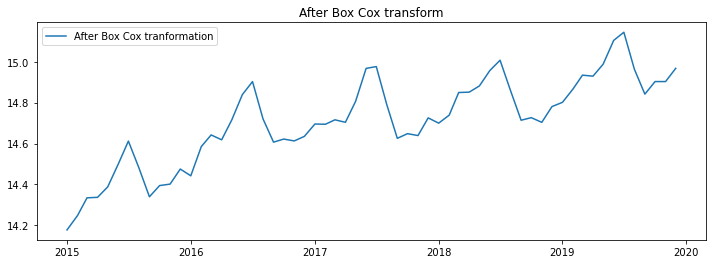

In [40]:
data_boxcox = pd.Series(boxcox(data['TTT'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [41]:
# Stationarity test:
result = adfuller(data_boxcox)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -3.447518
Critical Values at 0.05: -2.92
p-value: 0.009442
Stationary


In [42]:
kpss_test = kpss(data_boxcox)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values at 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])
if result[1] > 0.05:
    print('Stationary')
else:
    print('Not stationary')

KPSS Statistic: 1.066233
Critical Values at 0.05: 0.46
p-value: 0.010000
Not stationary


C:\Users\namtrantuan\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


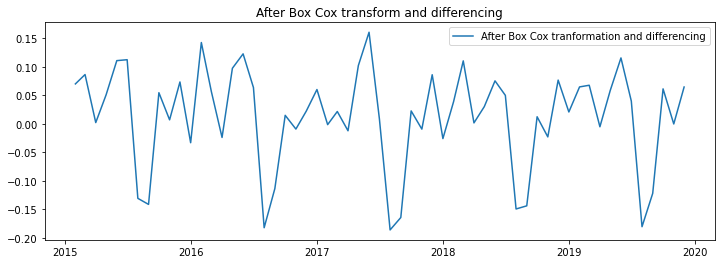

In [43]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [45]:
data_boxcox_diff.dropna(inplace=True)

In [46]:
# Stationarity test:
result = adfuller(data_boxcox_diff)
print('ADF Statistic: %f' % result[0])
print('Critical Values at 0.05: %.2f' % result[4]['5%'])
print('p-value: %f' % result[1])
if result[1] <= 0.05:
    print('Stationary')
else:
    print('Not stationary')

ADF Statistic: -1.631673
Critical Values at 0.05: -2.93
p-value: 0.466615
Not stationary
